<h1 style="text-align:center">Face Detection</h1>
<h3 style="text-align:center">By: <a href="https://www.kaggle.com/rafanthx13">Nancy Galicia</a>, <a href="https://www.kaggle.com/rafaelgreca">Álvaro García</a> and <a href="https://www.kaggle.com/rafaelmm">Omar Sanchez</a></h3>

<h3 >Table of contents</h3>

<div style="margin-top: 20px">
    <ol>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#libraries">Libraries</a></li>
        <li><a href="#data">Data</a></li>
        <li><a href="#model">Model</a></li>
        <li><a href="#training">Training</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ol>
</div>

<h2 id="introduction" style="text-align:center">Introduction</h2>

In this notebook we will create a face detection model. We will use the dataset "Labelled Faces in the Wild" (LFW) which contains images of faces of famous people, this is for images that contain faces. For images that do not contain faces, we will use the dataset "Jack", which contains random images. After getting the data, we will label it getting the bounding box of the faces. Then, we will use a pre-trained model to detect the faces in the images. We will use "MobileNetV2" as the pre-trained model. The model will be trained using the dataset we created. The technique we will use is transfer learning. Finally, we will evaluate the model using the test set.

<h2 id="libraries" style="text-align:center">Libraries</h2>

In [1]:
# For data
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
# For create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


from tensorflow.keras.utils import Sequence
import numpy as np

<h2 id="data" style="text-align:center">Data</h2>

<h3 style="text-align:center">Datasets</h3>

<h4 style="text-align:center">LFW | Jack</h4>

The datasets we will use are the following:

- LFW: This dataset contains images of faces of famous people. It contains 13,233 images of 5,749 people. This dataset is used for images that contain faces.

- Jack: This dataset contains random images. It contains 3,795 images. This dataset is used for images that do not contain faces.

<div style="justify-content:center; display:flex">
    <img src="Data/Test/Images/1_1.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/104_0.jpg" style="width: 250px; height: 250px"/>
</div>

<h3 style="text-align:center">Labeled Faces in the Wild</h3>

The dataset "Labeled Faces in the Wild" (LFW) contains images of faces of famous people. This dataset is used for images that contain faces. The dataset contains 13,233 images of 5,749 people. 

We have reduce the size of the dataset to 11,917 images. This was done to perform the quality of the dataset, where we removed the images in which there were more than one face.

The size of each image is 250x250 pixels.

<div style="justify-content:center; display:flex">
    <img src="Data/Test/Images/1_1.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/64_1.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/71_1.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/102_1.jpg" style="width: 250px; height: 250px"/>
</div>


<h3 style="text-align:center">Jack</h3>

The dataset "Jack" contains random images. The dataset contains 3,795 images. This dataset is used for images that do not contain faces, but some images contain faces, but they are not too clear or in a bad position.

We resize the images to 250x250 pixels.

<div style="justify-content:center; display:flex">
    <img src="Data/Test/Images/140_0.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/169_0.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/152_0.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/203_0.jpg" style="width: 250px; height: 250px"/>
</div>


<h3 style="text-align:center">Labeling data</h3>
<h4 style="text-align:center">Face | No face</h4>

<div style="justify-content:center; display:flex">
    <img src="Data/Test/Images/64_1.jpg" style="width: 250px; height: 250px"/>
    <img src="Data/Test/Images/203_0.jpg" style="width: 250px; height: 250px"/>
</div>

We have labeled the data getting 2 coordinates, the top left and the bottom right of the bounding box of the face. The coordinates are normalized, so they are between 0 and 1. We have created a JSON file with the data of the images. 

The JSON file has the following structure:

```json
{
    "image": "file_name.jpg",
    "bbox": [
        x1, 
        y1,
        x2,
        y2
    ]
    "class": 1|0
}
```
where:
- image: name of the image
- bbox: coordinates of the bounding box (x1, y1, x2, y2), where (x1, y1) is the top left coordinate and (x2, y2) is the bottom right coordinate
- class: 1 if the image contains a face, 0 if the image does not contain a face




<h4 style="text-align:center">Code</h4> 

In [33]:
# This function reads the coordinates of the face from the dataframe previously created and returns them, this csv file contains the coordinates of the face in the image
def get_coordinates(dataframe: pd.DataFrame, image_name: str):
    index = int(image_name.split('.')[0])

    face = dataframe.iloc[index]
    x, y, w, h = face['X'], face['Y'], face['Width'], face['Height']

    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h

    return [x1, y1, x2, y2]

def plot_image(image, coordinates):
    x1, y1, x2, y2 = coordinates
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

def createLabel(filename: str, bbox: list, class_id: int, json_file_name: str, img_size: list, json_folder: str ):
    # Convert the bbox to float
    bbox = [float(coord) for coord in bbox]

    # Normalize the bbox coordinates (values between 0 and 1)
    width, height = img_size   

    bbox[0] = bbox[0] / width
    bbox[1] = bbox[1] / height
    bbox[2] = bbox[2] / width
    bbox[3] = bbox[3] / height

    data = {
        "image": filename,
        "bbox": bbox,
        "class": class_id
    }
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)

    with open(f"{json_folder}/{json_file_name}", 'w') as json_file:
        json.dump(data, json_file)

def readLabelPlotImage(json_file_name: str, dataset: str):
    with open(json_file_name, 'r') as json_file:
        data = json.load(json_file)

    image = cv2.imread(f"{dataset}/{data['image']}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox = data['bbox']

    x1 = int(bbox[0] * 250)
    y1 = int(bbox[1] * 250)
    x2 = int(bbox[2] * 250)
    y2 = int(bbox[3] * 250)

    print(x1, y1, x2, y2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

70 65 164 188


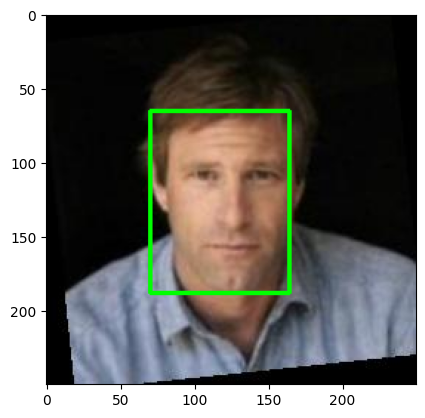

In [34]:
readLabelPlotImage("Data/Test/Labels/1_1.json", "Data/Test/Images")

<h3 style="text-align:center">Split data</h3>

We have split the data into training, validation and test sets. Where the training set contains 80% of the data, the validation set contains 10% of the data and the test set contains 10% of the data.

<lo>
    <li>Training set: 80% of the data</li>
    <li>Validation set: 10% of the data</li>
    <li>Test set: 10% of the data</li>
</lo>

In the split we have taken into account that the data is balanced, that is, the training, validation and test sets contain the same number of images with faces and without faces. So we have around 11000 images for faces and 3000 images for no faces.

<h2 id="model" style="text-align:center">Model</h2>

<h3 style="text-align:center">MobileNetV2</h3>

We will use the pre-trained model "MobileNetV2" to detect the faces in the images. The model is trained on the "ImageNet" dataset. The model has 155 layers and 3,504,872 parameters.

<div style="justify-content:center; display:flex">
    <img src="https://www.researchgate.net/publication/361260658/figure/fig1/AS:1179073011290112@1658124320675/The-architecture-of-MobileNetV2-DNN.png" style="width: 500px; height: 500px"/>
</div>

<br>

<div style="justify-content:center; display:flex">
    <img src="https://www.researchgate.net/publication/342856036/figure/fig3/AS:911929400885251@1594432320422/The-architecture-of-the-MobileNetv2-network.ppm" style="width: 500px; height: 250px"/>
</div>

In [ ]:
# Cargar MobileNetV2 preentrenado en ImageNet, excluyendo las capas superiores
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas base
base_model.trainable = False

# Añadir nuevas capas para la clasificación y la regresión
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Clasificación binaria (rostro/no rostro)
classification_output = Dense(1, activation='sigmoid', name='classification')(x)

# Regresión para el bounding box
regression_output = Dense(4, activation='sigmoid', name='bounding_box')(x)

# Crear el modelo final con dos salidas
model = Model(inputs=base_model.input, outputs=[classification_output, regression_output])

# Compilar el modelo
model.compile(optimizer='adam', 
              loss={'classification': 'binary_crossentropy', 'bounding_box': 'mean_squared_error'},
              metrics={'classification': 'accuracy', 'bounding_box': 'mse'})

# Resumen del modelo
model.summary()


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, image_folder, label_folder, batch_size=32, dim=(224, 224), shuffle=True):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_folder)]
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X, y_class, y_bbox = self.__data_generation(batch_ids)
        return X, {'classification': y_class, 'bounding_box': y_bbox}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __data_generation(self, batch_ids):
        X = np.empty((self.batch_size, *self.dim, 3))
        y_class = np.empty((self.batch_size, 1))
        y_bbox = np.empty((self.batch_size, 4))

        for i, id in enumerate(batch_ids):
            img_path = os.path.join(self.image_folder, id + '.jpg')
            label_path = os.path.join(self.label_folder, id + '.json')
            
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.dim)
            img = img / 255.0  # Normalización

            X[i,] = img
            y_class[i,] = label['class']
            boudingBox = label['bbox']
            y_bbox[i,] = label['bbox'] * 250 # Desnormalización


        return X, y_class, y_bbox

# Crear los generadores de datos
train_generator = DataGenerator('Data/Train/Images', 'Data/Train/Labels')
val_generator = DataGenerator('Data/Validation/Images', 'Data/Validation/Labels')
test_generator = DataGenerator('Data/Test/Images', 'Data/Test/Labels', shuffle=False)


<h2 id="training" style="text-align:center">Training</h2>

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # Ajusta el número de épocas según tus necesidades
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

<h2 id="evaluation" style="text-align:center">Evaluation</h2>

In [ ]:
# Evaluar el modelo
results = model.evaluate(test_generator)
if len(results) == 3:
    print(f"Loss: {results[0]}, Classification Accuracy: {results[1]}, Bounding Box MSE: {results[2]}")
else:
    print("Unexpected results format:", results)


In [ ]:
# Guardar el modelo
model.save('face_detection_v1.keras')

<h2 style="text-align:center">Using model</h2>

In [8]:
def detect_face(image_path, model):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    img_resized = img_resized / 255.0  # Normalización
    img_resized = np.expand_dims(img_resized, axis=0)

    pred_class, pred_bbox = model.predict(img_resized)
    pred_class = pred_class[0][0]
    pred_bbox = pred_bbox[0]

    if pred_class > 0.5:
        h, w, _ = img.shape
        x1 = int(pred_bbox[0] * w)
        y1 = int(pred_bbox[1] * h)
        x2 = int(pred_bbox[2] * w)
        y2 = int(pred_bbox[3] * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("No face detected")


In [7]:
model = tf.keras.models.load_model('face_detection_v1.keras') 

c:\Users\alvar\anaconda3\envs\ArtificialIntelligence\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


<h2 id="conclusion" style="text-align:center">Conclusion</h2>

112 104 262 300


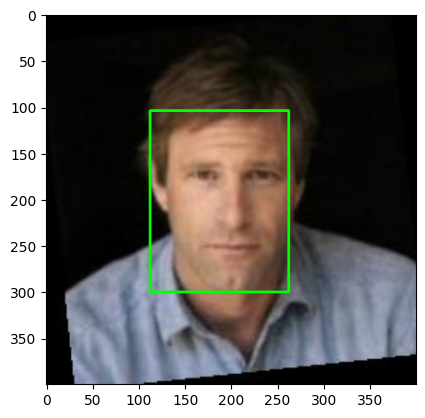

In [42]:
def plotImage(json_file_name: str, dataset: str):
    with open(json_file_name, 'r') as json_file:
        data = json.load(json_file)

    w, h = 400, 400
    image = cv2.imread(f"{dataset}/{data['image']}")
    image = cv2.resize(image, (w, h))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox = data['bbox']

    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    x2 = int(bbox[2] * w)
    y2 = int(bbox[3] * h)

    print(x1, y1, x2, y2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

plotImage('Data/Test/Labels/1_1.json', 'Data/Test/Images')